# L4: Optimize DSPy Agent with DSPy Optimizer

⏳ **Note (Kernel Starting)**: This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.

**Updated for Groq llama-3.1-8b-instant** - Conservative token usage and latest DSPy documentation

---

💻 **Access files**: Click "File" → "Open" to view `requirements.txt` and `helper.py`

⬇ **Download Notebook**: Click "File" → "Download as" → "Notebook (.ipynb)"

📒 **For more help**, please see the "Appendix – Tips, Help, and Download" Lesson.


In [1]:
# Cell 2: Setup Groq API Key
from helper import get_groq_api_key
import os

# Load Groq API key from environment
groq_api_key = get_groq_api_key()
os.environ["GROQ_API_KEY"] = groq_api_key

print("✓ Groq API key loaded and set in environment")

✓ Groq API key loaded and set in environment


In [2]:
# Cell 3: Configure MLflow Tracking
import mlflow
from helper import get_mlflow_tracking_uri

# Set up MLflow tracking server
mlflow_tracking_uri = get_mlflow_tracking_uri()
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment("dspy_course_4")

# Enable autologging with full optimization tracking
mlflow.dspy.autolog(
    log_evals=True,           # Log evaluation results
    log_compiles=True,        # Log compilation process
    log_traces_from_compile=True  # Log detailed traces during optimization
)

print("✓ MLflow tracking configured")
print(f"  URI: {mlflow_tracking_uri}")
print(f"  Experiment: dspy_course_4")


2026/02/16 12:19:00 INFO mlflow.tracking.fluent: Experiment with name 'dspy_course_4' does not exist. Creating a new experiment.
d:\User\Desktop\Acads\4th Year\TwoTabs Dir\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


✓ MLflow tracking configured
  URI: http://localhost:8080
  Experiment: dspy_course_4


In [3]:
# Cell 4: Configure DSPy with Groq LLM
import dspy

# Configure DSPy to use Groq's llama-3.1-8b-instant
lm = dspy.LM(
    'groq/llama-3.1-8b-instant',
    api_key=groq_api_key,
    max_tokens=512,      # Conservative token usage for RAG answers
    temperature=0.7      # Balance creativity and factual accuracy
)

dspy.configure(lm=lm)

print("✓ DSPy configured with Groq llama-3.1-8b-instant")
print(f"  Model: groq/llama-3.1-8b-instant")
print(f"  Max tokens: 512 (conservative)")
print(f"  Temperature: 0.7")

✓ DSPy configured with Groq llama-3.1-8b-instant
  Model: groq/llama-3.1-8b-instant
  Max tokens: 512 (conservative)
  Temperature: 0.7


In [4]:
# Cell 4.5: Install Visualization Libraries
# Install matplotlib for visualizations (if not already installed)
try:
    import matplotlib.pyplot as plt
    print("✓ matplotlib already available")
except ImportError:
    print("Installing matplotlib...")
    %pip install matplotlib
    import matplotlib.pyplot as plt
    print("✓ matplotlib installed and imported")

# Configure matplotlib for better notebook display
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✓ Visualization setup complete")

✓ matplotlib already available
✓ Visualization setup complete


## Build a RAG Agent

We'll create a Wikipedia-based Retrieval-Augmented Generation (RAG) agent using DSPy's ReAct module.

**ReAct** = Reasoning + Acting - The agent decides when to search for more information before answering.


In [5]:
# Cell 6: Define Wikipedia Search Tool
def search_wikipedia(query: str) -> list[str]:
    """
    Search Wikipedia abstracts and return top 3 relevant text chunks.
    
    Args:
        query: Search query string
        
    Returns:
        List of text chunks from Wikipedia
    """
    results = dspy.ColBERTv2(url="http://20.102.90.50:2017/wiki17_abstracts")(query, k=3)
    return [x["text"] for x in results]

print("✓ Wikipedia search tool defined")
print("  Data source: Wikipedia abstracts (ColBERTv2)")
print("  Returns: Top 3 relevant chunks per query")


✓ Wikipedia search tool defined
  Data source: Wikipedia abstracts (ColBERTv2)
  Returns: Top 3 relevant chunks per query


In [6]:
# Cell 7: Create ReAct Agent
react = dspy.ReAct("question -> answer", tools=[search_wikipedia])

print("✓ ReAct agent created")
print("  Input: question")
print("  Output: answer")
print("  Tools: [search_wikipedia]")
print("  Agent will autonomously decide when to search for information")

✓ ReAct agent created
  Input: question
  Output: answer
  Tools: [search_wikipedia]
  Agent will autonomously decide when to search for information


## Load Training and Validation Datasets

We'll use a subset of the **HotpotQA** dataset - a question-answering benchmark based on Wikipedia data.

- **Training set**: Used to bootstrap few-shot examples
- **Validation set**: Used to evaluate candidate programs during optimization
- **Dataset size**: Can be as small as 20 records (unlike traditional ML)


In [7]:
# Cell 9: Load Training Dataset
import json

# Load training set
trainset = []
with open("trainset.jsonl", "r") as f:
    for line in f:
        example = dspy.Example(**json.loads(line))
        trainset.append(example.with_inputs("question"))

print(f"✓ Training set loaded: {len(trainset)} examples")

✓ Training set loaded: 100 examples


In [8]:
# Cell 10: Load Validation Dataset

# Load validation set
valset = []
with open("valset.jsonl", "r") as f:
    for line in f:
        example = dspy.Example(**json.loads(line))
        valset.append(example.with_inputs("question"))

print(f"✓ Validation set loaded: {len(valset)} examples")


✓ Validation set loaded: 100 examples


In [9]:
# Cell 11: Inspect Dataset Sample

# Overview of the dataset structure
print("=" * 70)
print("SAMPLE TRAINING EXAMPLE:")
print("=" * 70)
print(trainset[0])
print("=" * 70)
print("\nDataset structure:")
print("  - 'question': Input field")
print("  - 'answer': Expected output (ground truth)")


SAMPLE TRAINING EXAMPLE:
Example({'question': 'Are Smyrnium and Nymania both types of plant?', 'answer': 'yes'}) (input_keys={'question'})

Dataset structure:
  - 'question': Input field
  - 'answer': Expected output (ground truth)


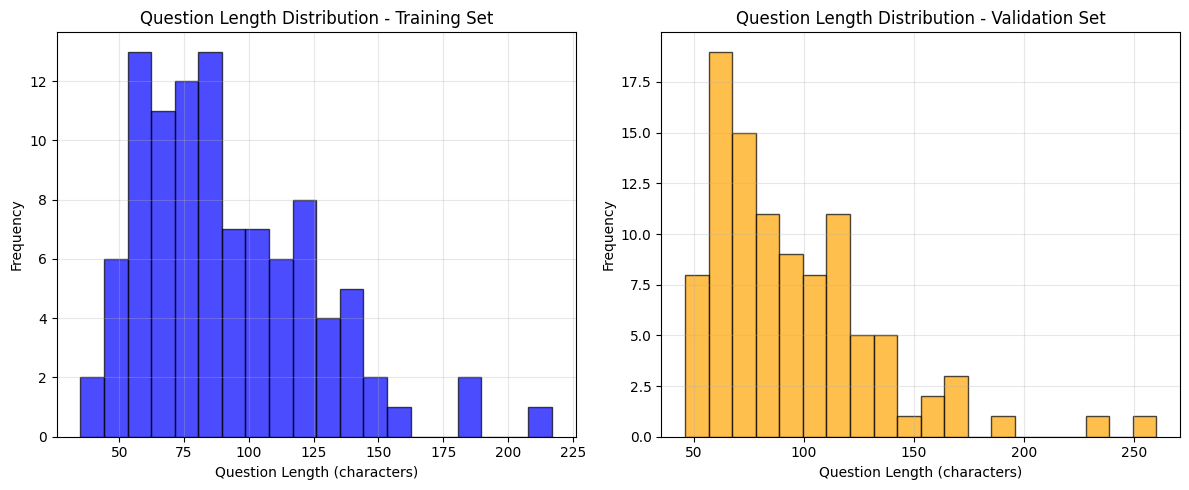

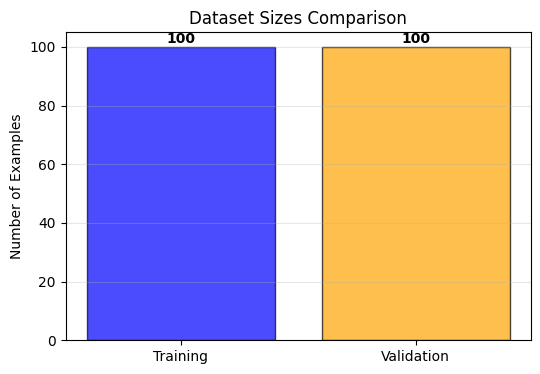

✓ Dataset visualizations generated
  Training set: 100 examples, avg question length: 91.0 chars
  Validation set: 100 examples, avg question length: 95.3 chars


In [10]:
# Cell 11.5: Visualize Dataset Statistics
import matplotlib.pyplot as plt

# Calculate question lengths
train_lengths = [len(ex.question) for ex in trainset]
val_lengths = [len(ex.question) for ex in valset]

# Plot histograms of question lengths
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Question Length Distribution - Training Set')
plt.xlabel('Question Length (characters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(val_lengths, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Question Length Distribution - Validation Set')
plt.xlabel('Question Length (characters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot dataset sizes comparison
plt.figure(figsize=(6, 4))
datasets = ['Training', 'Validation']
sizes = [len(trainset), len(valset)]
bars = plt.bar(datasets, sizes, color=['blue', 'orange'], alpha=0.7, edgecolor='black')
plt.title('Dataset Sizes Comparison')
plt.ylabel('Number of Examples')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{size}', ha='center', va='bottom', fontweight='bold')

plt.show()

print("✓ Dataset visualizations generated")
print(f"  Training set: {len(trainset)} examples, avg question length: {sum(train_lengths)/len(train_lengths):.1f} chars")
print(f"  Validation set: {len(valset)} examples, avg question length: {sum(val_lengths)/len(val_lengths):.1f} chars")

## Configure MIPROv2 Optimizer

**MIPROv2** (Multi-prompt Instruction Proposal Optimizer v2) automatically optimizes:

1. **Prompt Templates** - Generates comprehensive instructions for each module
2. **Few-Shot Examples** - Bootstraps high-quality demonstrations from training data

### How it works:
1. **Bootstrap** examples by running training data through the program
2. **Generate** instruction candidates using the LLM
3. **Sample** combinations of instructions + few-shot examples
4. **Evaluate** each candidate program on validation set
5. **Select** the best performing configuration

**Auto mode options:**
- `light`: Fast optimization (recommended for getting started)
- `medium`: Balanced optimization
- `heavy`: Thorough optimization (more time/cost)


In [11]:
# Cell 13: Setup MIPROv2 Optimizer
tp = dspy.MIPROv2(
    metric=dspy.evaluate.answer_exact_match,  # How to score program outputs
    auto="light",      # Conservative optimization mode
    num_threads=16     # Parallel evaluation threads
)

print("✓ MIPROv2 Optimizer configured")
print("  Metric: answer_exact_match")
print("  Mode: light (fast, conservative)")
print("  Threads: 16 (parallel evaluation)")
print("\nThe optimizer will:")
print("  1. Bootstrap few-shot examples from training data")
print("  2. Generate instruction candidates via LLM")
print("  3. Evaluate combinations on validation set")
print("  4. Select best performing configuration")


✓ MIPROv2 Optimizer configured
  Metric: answer_exact_match
  Mode: light (fast, conservative)
  Threads: 16 (parallel evaluation)

The optimizer will:
  1. Bootstrap few-shot examples from training data
  2. Generate instruction candidates via LLM
  3. Evaluate combinations on validation set
  4. Select best performing configuration


## Load Cache and Run Optimization

⏱️ **Note**: We're using a pre-computed cache (`memory_cache.pkl`) to speed up the process for this demo.

In production, you can run without cache - the optimizer will make real LLM calls.

🔄 **Optimization Process** (typically 5-15 minutes without cache):
- Tests multiple candidate programs
- Continuously tracks and improves scores
- Uses statistical sampling to find optimal configuration


In [13]:
# Cell 15: Load Memory Cache
# dspy.cache.load_memory_cache("./memory_cache.pkl")  # Commented out - cache API may have changed in DSPy 2.6

print("✓ Memory cache loading skipped (cache API not available in current DSPy version)")
print("  In production: Check DSPy documentation for current cache loading method")
print("  Proceeding with fresh optimization (will make real LLM calls)")


✓ Memory cache loading skipped (cache API not available in current DSPy version)
  In production: Check DSPy documentation for current cache loading method
  Proceeding with fresh optimization (will make real LLM calls)


In [ ]:
# Cell 16: Compile Optimized Program
print("=" * 70)
print("STARTING OPTIMIZATION PROCESS")
print("=" * 70)
print("This will:")
print("  - Bootstrap few-shot examples")
print("  - Generate instruction candidates")
print("  - Evaluate candidate programs")
print("  - Track results in MLflow")
print("\n🔄 Compiling...\n")

optimized_react = tp.compile(
    react,
    trainset=trainset,
    valset=valset,
    requires_permission_to_run=False,  # Skip confirmation prompt
)

print("\n" + "=" * 70)
print("✓ OPTIMIZATION COMPLETE!")
print("=" * 70)


2026/02/16 12:19:43 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



STARTING OPTIMIZATION PROCESS
This will:
  - Bootstrap few-shot examples
  - Generate instruction candidates
  - Evaluate candidate programs
  - Track results in MLflow

🔄 Compiling...



2026/02/16 12:19:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e7438be51b6346ef8899a9aa8fe0e8b8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current dspy workflow
2026/02/16 12:19:45 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: True
num_candidates: 3
valset size: 100

2026/02/16 12:19:45 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2026/02/16 12:19:45 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2026/02/16 12:19:45 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=3 sets of demonstrations...


Bootstrapping set 1/3
Bootstrapping set 2/3
Bootstrapping set 3/3


  0%|          | 0/100 [00:00<?, ?it/s]d:\User\Desktop\Acads\4th Year\TwoTabs Dir\.venv\Lib\site-packages\pydantic\main.py:528: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 5: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content="[[ ## ne...er_specific_fields=None), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [field_name='choices', input_value=Choices(finish_reason='st...r_specific_fields=None)), input_type=Choices])
  return self.__pydantic_serializer__.to_json(
d:\User\Desktop\Acads\4th Year\TwoTabs Dir\.venv\Lib\site-packages\pydantic\main.py:528: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 5: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content='[[ ## ne.

## Inspect Optimized Components

Let's examine what the optimizer changed in our ReAct agent:

### Original Program:
- **Signature**: Simple `question -> answer` with no instructions
- **Demos**: No few-shot examples

### Optimized Program:
- **Signature**: Enhanced with comprehensive instructions
- **Demos**: Bootstrapped few-shot examples showing good reasoning traces


In [ ]:
# Cell 18: View Optimized Signature
print("=" * 70)
print("ORIGINAL SIGNATURE:")
print("=" * 70)
print("question -> answer")
print("(No instructions)")

print("\n" + "=" * 70)
print("OPTIMIZED SIGNATURE:")
print("=" * 70)
print(optimized_react.react.signature)
print("\n✓ Notice the comprehensive instructions added by the optimizer!")


In [ ]:
# Cell 19: View Optimized Demos
print("=" * 70)
print("OPTIMIZED FEW-SHOT EXAMPLES (Demos):")
print("=" * 70)
print(f"\nNumber of demos: {len(optimized_react.react.demos)}")

if optimized_react.react.demos:
    print("\n--- First Demo ---")
    print(optimized_react.react.demos[0])
    print("\n✓ These are bootstrapped examples showing successful reasoning traces")
else:
    print("No demos found")


## Evaluate Performance

Now let's compare the **original** vs **optimized** agent performance on the validation set.

**Metric**: Exact Match - The answer must match the ground truth exactly.

We'll see how much improvement the optimizer achieved without any manual prompt engineering!


In [ ]:
# Cell 21: Setup Evaluator
evaluator = dspy.Evaluate(
    metric=dspy.evaluate.answer_exact_match,  # Exact match scoring
    devset=valset,          # Evaluation dataset
    display_table=True,     # Show results table
    display_progress=True,  # Show progress bar
    num_threads=24,         # Parallel evaluation
)

print("✓ Evaluator configured")
print(f"  Metric: answer_exact_match")
print(f"  Evaluation set: {len(valset)} examples")
print(f"  Threads: 24")


In [ ]:
# Cell 22: Evaluate Original Agent
print("=" * 70)
print("EVALUATING ORIGINAL REACT AGENT")
print("=" * 70)
print("Running evaluation on validation set...")
print("(This shows baseline performance without optimization)\n")

original_score = evaluator(react)

print("\n" + "=" * 70)
print(f"📊 ORIGINAL SCORE: {original_score:.4f} ({original_score*100:.2f}%)")
print("=" * 70)


In [ ]:
# Cell 23: Evaluate Optimized Agent
print("\n" + "=" * 70)
print("EVALUATING OPTIMIZED REACT AGENT")
print("=" * 70)
print("Running evaluation on validation set...")
print("(This shows performance after MIPROv2 optimization)\n")

optimized_score = evaluator(optimized_react)

print("\n" + "=" * 70)
print(f"📊 OPTIMIZED SCORE: {optimized_score:.4f} ({optimized_score*100:.2f}%)")
print("=" * 70)


In [ ]:
# Cell 24: Performance Comparison
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON SUMMARY")
print("=" * 70)
print(f"\n{'Metric':<20} {'Original':<15} {'Optimized':<15} {'Improvement':<15}")
print("-" * 70)

original_pct = original_score * 100
optimized_pct = optimized_score * 100
improvement = optimized_pct - original_pct
relative_gain = (improvement / original_pct * 100) if original_pct > 0 else 0

print(f"{'Exact Match Score':<20} {original_pct:>6.2f}%{'':<8} {optimized_pct:>6.2f}%{'':<8} +{improvement:>5.2f}%")
print(f"{'Relative Gain':<20} {'':<15} {'':<15} {relative_gain:>6.1f}%")

print("\n" + "=" * 70)
print("✨ ACHIEVEMENT UNLOCKED: Automatic Prompt Engineering!")
print("=" * 70)
print("\nWithout ANY manual prompt engineering, the MIPROv2 optimizer:")
print(f"  ✓ Generated optimized instructions automatically")
print(f"  ✓ Bootstrapped high-quality few-shot examples")
print(f"  ✓ Improved performance by {improvement:.2f} percentage points")
print(f"  ✓ Achieved {relative_gain:.1f}% relative improvement")
print("\nThis is the power of DSPy Optimization!")


In [ ]:
# Cell 24.5: Visualize Performance Comparison
import matplotlib.pyplot as plt

# Prepare data for comparison
scores = [original_score * 100, optimized_score * 100]
labels = ['Original Agent', 'Optimized Agent']
colors = ['#FF6B6B', '#4ECDC4']  # Red for original, teal for optimized

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, scores, color=colors, alpha=0.8, edgecolor='black', width=0.6)

# Add title and labels
plt.title('DSPy Agent Performance Comparison\n(Exact Match Score)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, max(scores) * 1.2)  # Add some headroom
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{score:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add improvement annotation
improvement = optimized_score * 100 - original_score * 100
if improvement > 0:
    plt.annotate(f'Improvement: +{improvement:.2f}%', 
                 xy=(1, optimized_score * 100), 
                 xytext=(0.5, (original_score + optimized_score)/2 * 100 + 5),
                 ha='center', fontsize=10, color='green',
                 arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

plt.tight_layout()
plt.show()

# Additional visualization: Performance gauge-style chart
fig, ax = plt.subplots(figsize=(8, 2), subplot_kw=dict(projection='polar'))
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim(0, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])

# Plot arcs for scores
theta_original = original_score * 180
theta_optimized = optimized_score * 180

ax.barh(0.5, theta_original/180, left=0, height=0.3, color='#FF6B6B', alpha=0.7)
ax.barh(0.5, theta_optimized/180, left=0, height=0.3, color='#4ECDC4', alpha=0.7)

# Add labels
ax.text(0, 0.7, '0%', ha='center', va='bottom', fontsize=10)
ax.text(180, 0.7, '100%', ha='center', va='bottom', fontsize=10)
ax.text(theta_original, 0.3, f'Original\n{original_score*100:.1f}%', ha='center', va='top', fontsize=9, color='white', fontweight='bold')
ax.text(theta_optimized, 0.3, f'Optimized\n{optimized_score*100:.1f}%', ha='center', va='top', fontsize=9, color='white', fontweight='bold')

ax.set_title('Performance Gauge: Before vs After Optimization', fontsize=12, fontweight='bold', pad=20)
plt.show()

print("✓ Performance comparison visualizations generated")
print(f"  Original Score: {original_score*100:.2f}%")
print(f"  Optimized Score: {optimized_score*100:.2f}%")
print(f"  Absolute Improvement: +{improvement:.2f} percentage points")
print(f"  Relative Improvement: +{relative_gain:.1f}%")